# Group Project Report
**Section 6 | Group 3**

In [34]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)

# Introduction

   Heart disease has become one of the leading causes of death, occupying a fifth of American deaths in 2020. As such, we must educate ourselves and become aware of the several possible factors that may lead to cardiovascular diseases. One of the main causes of heart disease is high blood pressure. It is known to decrease blood and oxygen supply to the heart, which can lead to heart attacks or heart failure (https://www.cdc.gov/bloodpressure/about.htm). Given that heart disease can still occur in individuals deemed healthy and young, age is still a factor that increases the likelihood that someone may encounter heart problems (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/). Similarly, the association seen between age, cholesterol levels, obesity, and several other health concerns suggests that a combined effect between these factors play a role in increasing the risk of getting heart disease (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/). Simply put, there is an evident correlation between age, blood pressure, and cholesterol levels with cardiovascular diseases. We decided to study the combined effect of these three factors on the presence of heart disease. *Can a given blood pressure, age and blood cholesterol value(s) be used to accurately predict if a patient has heart disease or not?*
    
   (https://canvas.ubc.ca/courses/106510/assignments/1419852?module_item_id=5168273)
   This is the Cleveland dataset from the “Heart Disease Data Set” on the UCI Machine Learning Repository, which conducted analysis on 303 participants to measure different predictors as well as the presence/absence of heart disease in 1988. The project identified 14 attributes as its columns, such as the age and sex of participants, as well as predictors including their resting heart pressure, blood cholesterol levels, and chest pain type. There was also the predicted attribute column with values ranging from 0 (no heart disease), to 4 (1, 2, 3 and 4 all referring to the presence of heart disease). The study’s goal was to look at the relationship between the 13 predictors and the presence/absence of heart disease. 


# Methods
We will be using the following columns, chosen based on the research outlined in the introduction: serum cholesterol levels (chol)(mg/dl); age (years); resting blood pressure (mm Hg), and the predictive class (presence/absence of heart disease). The steps we will take to visualize our results are:
1. We will first clean, wrangle, and split our data into training and testing data (75% training, 25% testing)
2. After some exploratory training data anaylsis, we will scale and center the data to ensure our predictors are on a comparable scale
3. Next, we will create our classification model using the training data

    a. This will be a K-nearest neighbor classification 
    
    b. We will need to pick the best K by using cross-validation (splitting training data into training and evaluating/validation data)
    
    c. After choosing the most accurate K, we will perform a K-nearest neighbor 
           classification on our testing data using the model
4. We will then visualize our results in a few ways:

    a. Visualizing our model, we will create a graph comparing the different predictors (on the axis) and colored by classification (presence/absence of heart disease)
    
    b. We will then fit our testing data (plotting it) against the predictors to represent the predictions using the model.
    
5. Our final step will be evaluating the accuracy of our model in terms of its ability to classify the testing data

    a. We will do this by calculating our prediction accuracy (total number of correct predictions divided by total number of predictions (testing data))
    
    b. We will also create a scatterplot that compares the predicted values and the observed values for this training data to visualize the accuracy of our model


In [78]:
# reading in data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart <- read_delim(url, delim = ",", 
                    col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","predicted_attribute"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Table 1: The first six rows of the raw dataset**

In [36]:
head(heart)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,predicted_attribute
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Cleaning and wrangling data:

Here we select only the columns we will be using and also edited the column names to make more sense for the reader. We will only be using the columns for age, resting blood pressure (mm Hg), cholesterol (mg/dl), and the heart disease diagnosis (yes or no). 

In [37]:
heart_clean <- select(heart, "age", "trestbps", "chol", "predicted_attribute")
colnames(heart_clean) <- c("age","blood_pressure","cholesterol","heart_diagnosis")

**Table 2: The first six rows of the raw dataset after renaming and choosing specific columns**

In [38]:
head(heart_clean)

age,blood_pressure,cholesterol,heart_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,0
67,160,286,2
67,120,229,1
37,130,250,0
41,130,204,0
56,120,236,0


The heart_diagnosis column has observations 0, 1, 2, 3, and 4, 

0 equates to the absence of heart disease (i.e. less than 50% vessel narrowing)

1-4 all equate to the presence of heart disease (i.e. more than 50% vessel narrowing).

We compiled numbers 1-4 to equal "yes" for presence of heart disease and 
0 to equal "no" for the absence of heart disease. The heart disease diagnosis is changed to a factor.

In [39]:
heart_filter <- filter(heart_clean, heart_diagnosis == 1 | heart_diagnosis == 2 | heart_diagnosis == 3 |heart_diagnosis == 4)|>
    mutate(heart_diagnosis = "yes")
heart_data <- filter(heart_clean, heart_diagnosis == 0)|>
    mutate(heart_diagnosis = "no")|>
    bind_rows(heart_filter)|>
    mutate(heart_diagnosis = as.factor(heart_diagnosis))

**Table 3: The first six rows of the cleaned heart dataset**

In [40]:
head(heart_data)

age,blood_pressure,cholesterol,heart_diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,no
37,130,250,no
41,130,204,no
56,120,236,no
57,120,354,no
57,140,192,no


Next, we will splitting data into a training set and testing set

In [41]:
set.seed(1145)
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_diagnosis)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

Here we provide a summary table of average age, average blood pressure, and average cholesterol level for each heart disease class.

Then, we counted the number of individuals with and without heart disease.

In [42]:
heart_summary <- heart_training |>
    group_by(heart_diagnosis)|>
    summarize(average_age = mean(age), 
              average_bp = mean(blood_pressure),
              average_c = mean(cholesterol))

**Table 4: A summary table of the training heart dataset that contains the average value of each column for each heart disease class**

In [43]:
heart_summary

heart_diagnosis,average_age,average_bp,average_c
<fct>,<dbl>,<dbl>,<dbl>
no,52.18699,128.7073,241.3008
yes,56.72115,135.1346,251.5577


In [44]:
heart_count <- heart_training |>
    group_by(heart_diagnosis)|>
    summarize(count = n())

**Table 5: The count of each heart disease class in the training heart dataset**

In [45]:
heart_count

heart_diagnosis,count
<fct>,<int>
no,123
yes,104


We plotted each predictor against each other with the heart diagnosis set as the colour for a total of 3 graphs. This exploratory analysis was to see how each predictor varied with the heart diagnosis.

In [46]:
options(repr.plot.width = 10, repr.plot.height = 8)
Age_Cholesterol_plot <- heart_training |>
    ggplot(aes(x = age, y = cholesterol, color = heart_diagnosis)) +
    geom_point(size = 3) +
    labs(x = "Age", y = "Cholesterol (mg/dl)", color = "Heart Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_color_brewer(palette = "Set3") +
    ggtitle("Age vs. Cholesterol")

**Graph 1: Age plotted against Cholesterol levels**

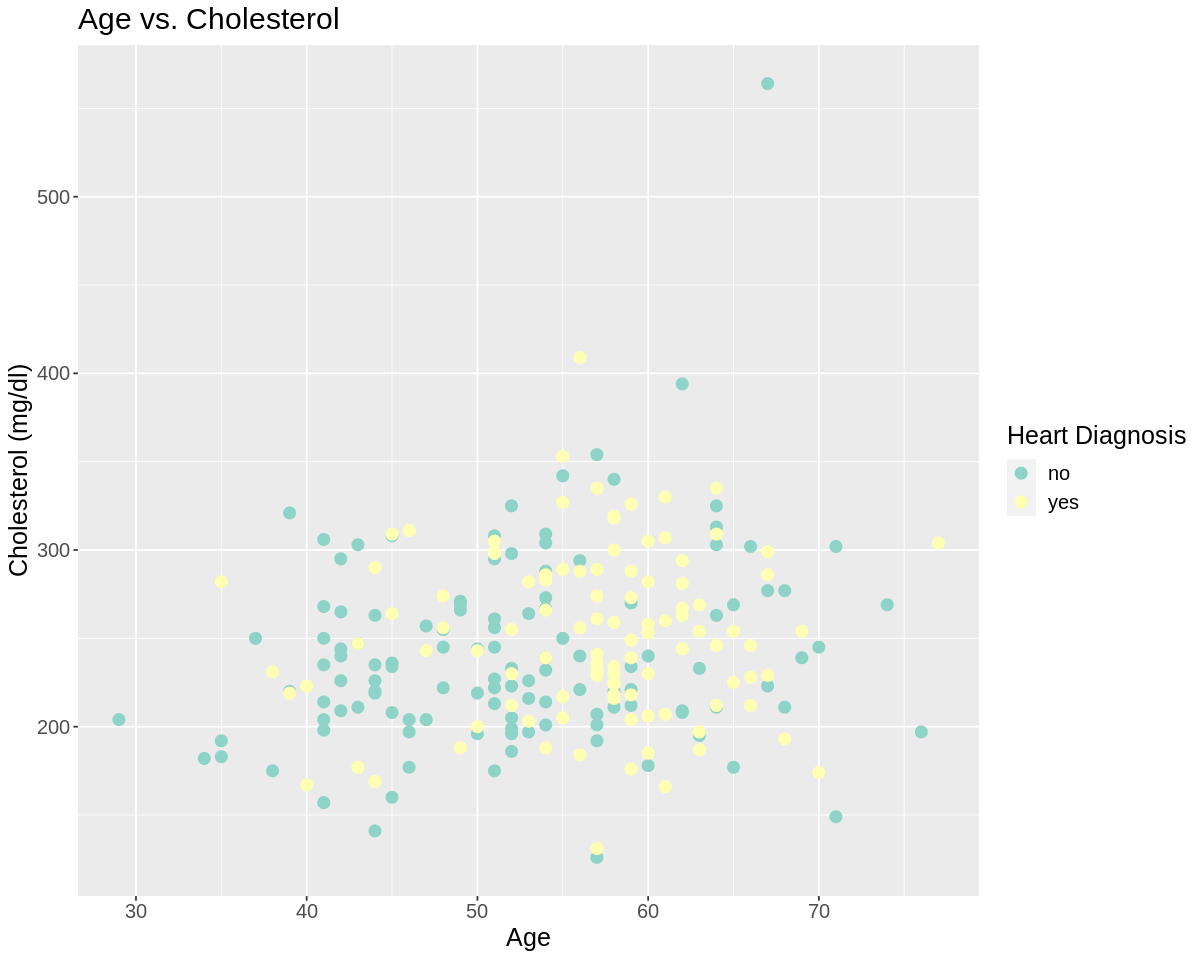

In [47]:
Age_Cholesterol_plot

In [90]:
options(repr.plot.width = 10, repr.plot.height = 8)
Age_BloodPressure_plot <- heart_training |>
    ggplot(aes(x = age, y = blood_pressure, color = heart_diagnosis)) +
    geom_point(size = 3) +
    labs(x = "Age", y = "Blood Pressure (mmHg)", color = "Heart Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_color_brewer(palette = "Set1") +
    ggtitle("Age vs. Blood Pressure")

**Graph 2: Age plotted against blood pressure**

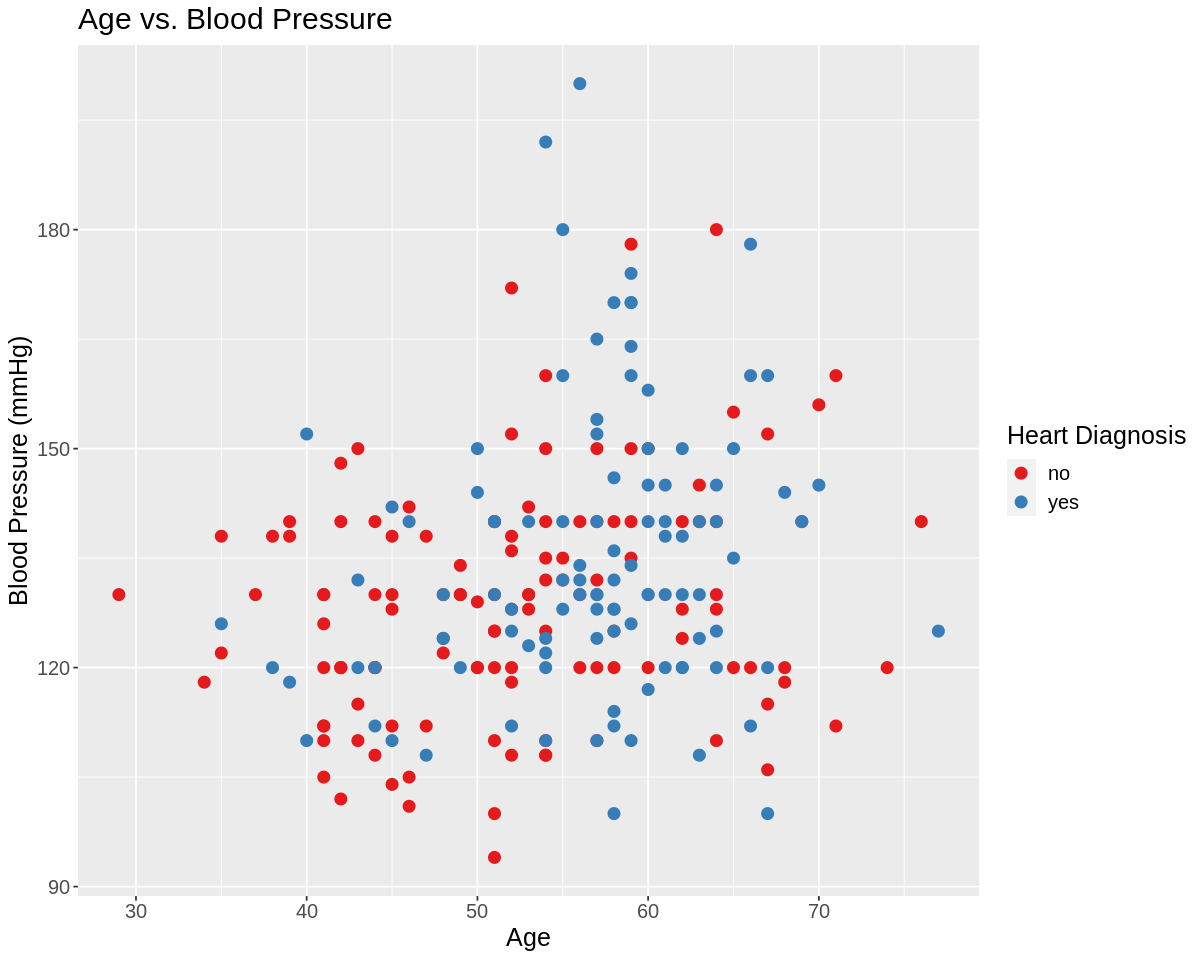

In [91]:
Age_BloodPressure_plot

In [92]:
options(repr.plot.width = 10, repr.plot.height = 8)
BloodPressure_Cholesterol_plot <- heart_training |>
    ggplot(aes(x = blood_pressure, y = cholesterol, color = heart_diagnosis)) +
    geom_point(size = 3) +
    labs(x = "Blood Pressure(mmHg)", y = "Cholesterol (mg/dl)", color = "Heart Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_color_brewer(palette = "Set2") +
    ggtitle("Blood Pressure vs. Cholesterol")

**Graph 3: Blood pressure plotted against cholesterol levels**

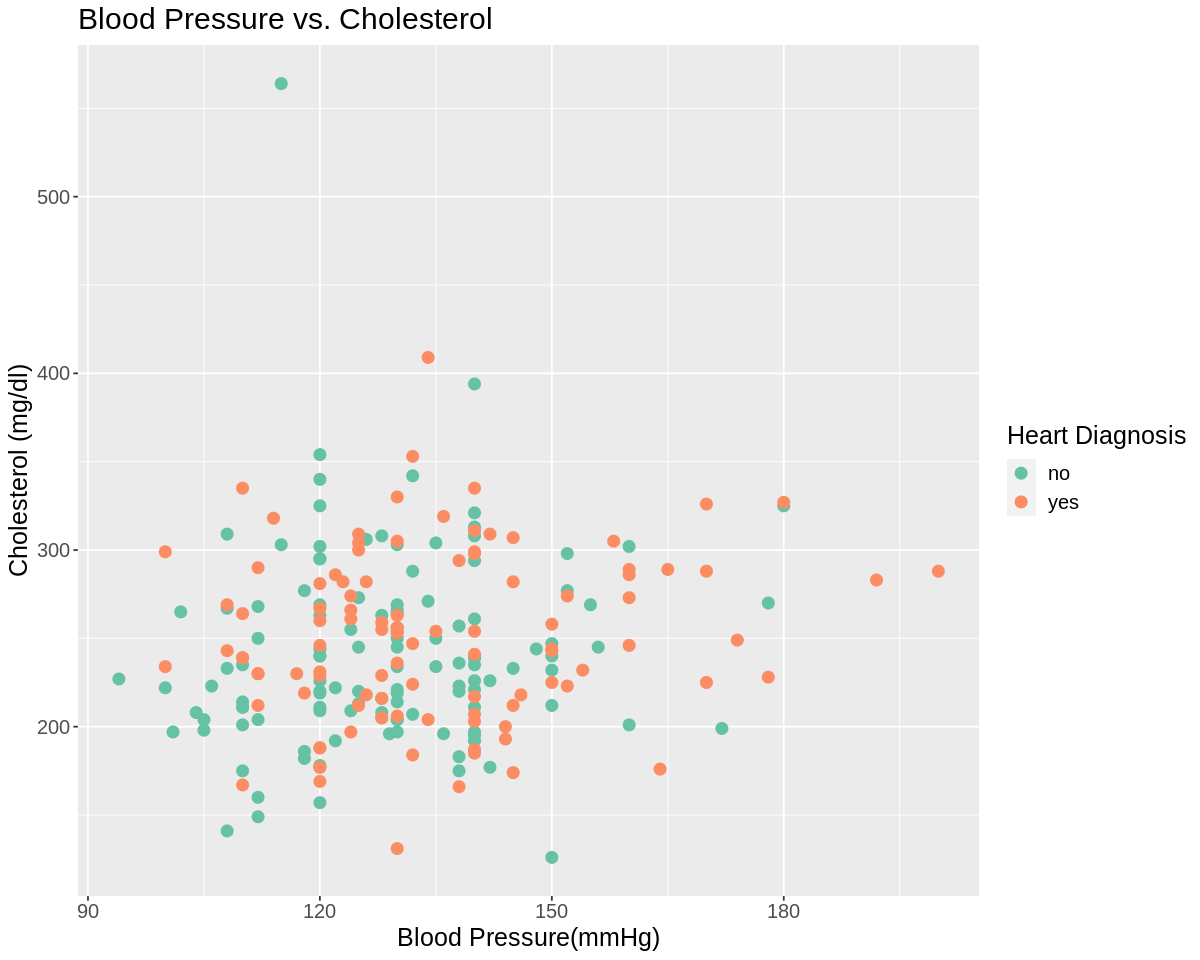

In [93]:
BloodPressure_Cholesterol_plot

Next, we create a k-nearest neighbours classification model on our training data after finding the K value that gives us the highest accuracy. First, we scale the data.

In [52]:
heart_recipe <- recipe(heart_diagnosis ~ age + blood_pressure + cholesterol, data = heart_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

Then, we choose a K value by performing a 5-fold cross validation to determine the K value between 1 and 50 that has the highest accuracy.

In [53]:
heart_vfold <- vfold_cv(heart_training, v =5, strata = heart_diagnosis)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from =1, to = 50, by = 1))

knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()

We now collect the accuracies of the different K values and then display them as a graph of K versus accuracy to determine the appropriate value. We also provide the table to assess the numbers individually.

In [54]:
accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate of Each K-neighbors") +
    theme(text = element_text(size = 16))

**Graph 4: A graph of the K values and its respective accuracy**

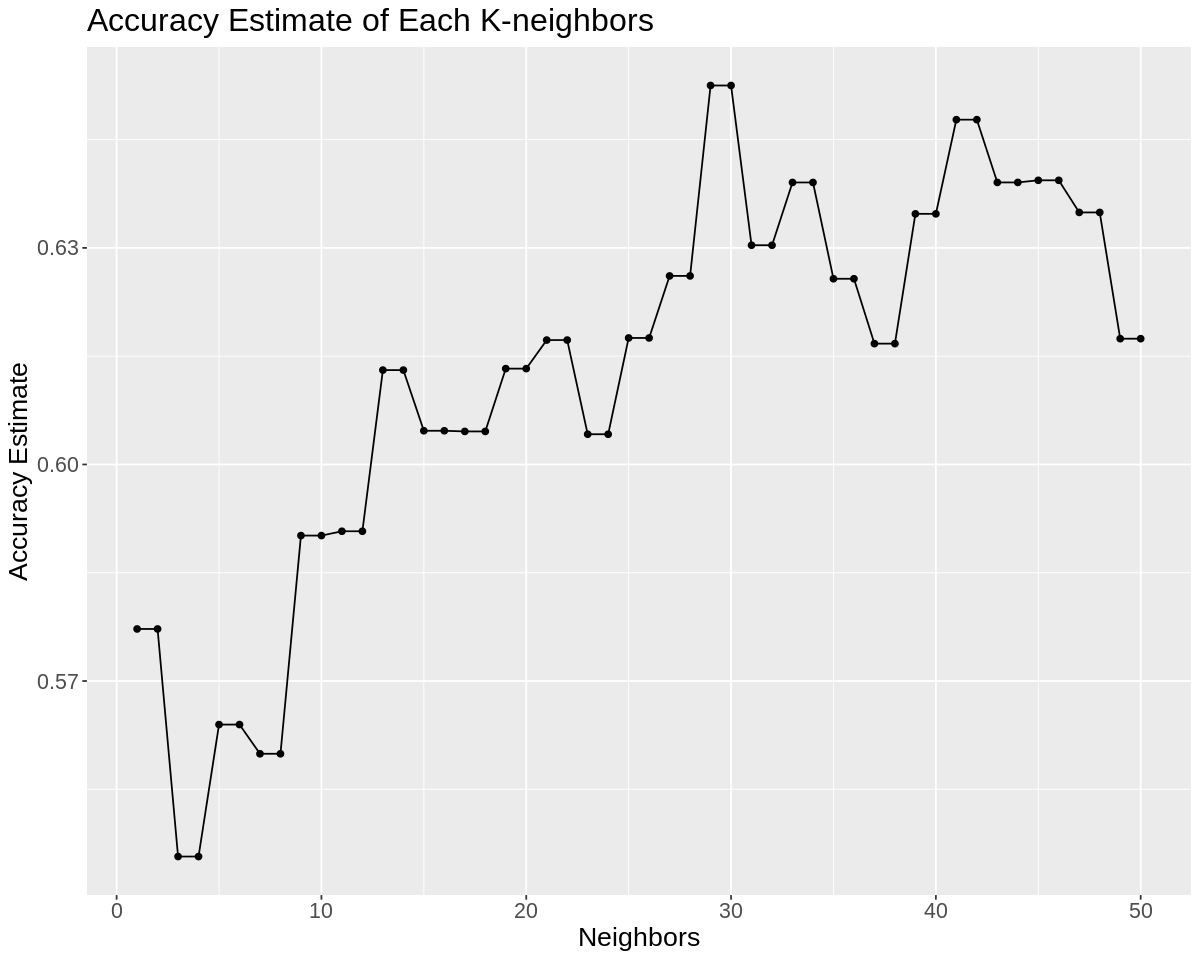

In [55]:
accuracy_vs_k

**Table 6: The number of neighbors with the top 6 highest accuracy**

In [61]:
new_accuracies <- accuracies|>
arrange(desc(mean))

head(new_accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,accuracy,binary,0.6524989,5,0.02341805,Preprocessor1_Model29
30,accuracy,binary,0.6524989,5,0.02341805,Preprocessor1_Model30
41,accuracy,binary,0.6477646,5,0.01421553,Preprocessor1_Model41
42,accuracy,binary,0.6477646,5,0.01421553,Preprocessor1_Model42
45,accuracy,binary,0.6393632,5,0.02964575,Preprocessor1_Model45
46,accuracy,binary,0.6393632,5,0.02964575,Preprocessor1_Model46


We ended up choosing 30 rather than 29 as the most accurate K. This was because k = 30 has immediate neighbours (k = 29 has 0.6524989 accuracy and k = 31 has 0.6303689 accuracy) that have less variability than 29 (k = 28 has 0.6261177 accuracy and k = 30 has 0.6524989 accuracy).

Now we create the classification model with the chosen k value on the training set.

In [66]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 30)|>
    set_engine("kknn")|>
    set_mode("classification")

# Creating a workflow with the previously made recipe that had scaled data
knn_fit <- workflow()|>
    add_recipe(heart_recipe)|>
    add_model(knn_spec)|>
    fit(data = heart_training)

# Results

Here we use the classification model on the testing set to find the accuracy of our model.

In [83]:
heart_test_prediction <- predict(knn_fit, heart_testing)|>
    bind_cols(heart_testing)

heart_prediction_accuracy <- heart_test_prediction |>
         metrics(truth = heart_diagnosis, estimate = .pred_class)|>
        filter(.metric == "accuracy")

Confusion <- heart_test_prediction |>
    conf_mat(truth =  heart_diagnosis, estimate = .pred_class)

**Table 7: The prediction accuracy results of the classification model on the testing set**

In [85]:
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5526316


**Table 8: The correct and incorrect predictions on the testing set**

In [86]:
Confusion

          Truth
Prediction no yes
       no  20  13
       yes 21  22

We decided to create a visualization that showed the true heart diagnosis as well as the predicted ones of the testing set. To do this, we plotted each predictor against each other, with the plot points coloured by the true heart diagnosis and a background colour of what was predicted.

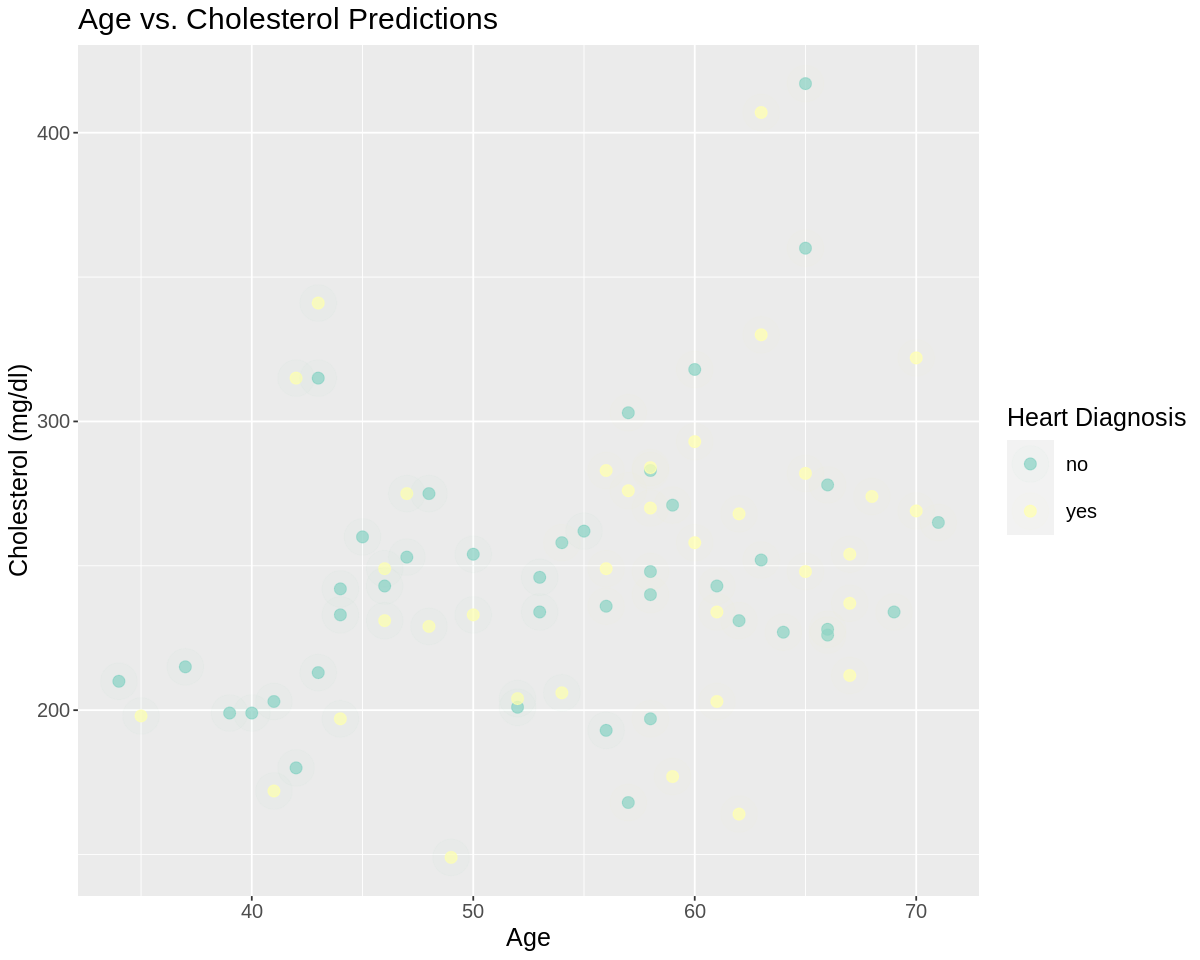

In [130]:
options(repr.plot.width = 10, repr.plot.height = 8)
heart_plot <- ggplot() +
    geom_point(data = heart_test_prediction,
               mapping = aes(x = age, y = cholesterol, color = heart_diagnosis),
               alpha = 0.75, size = 3) +
    geom_point(data = heart_test_prediction,
               mapping = aes(x = age, y = cholesterol, color = .pred_class),
               alpha = 0.02,
               size = 10) +
    scale_color_brewer(palette = "Set3") +
    labs(x = "Age", y = "Cholesterol (mg/dl)", title = "Age vs. Cholesterol Predictions", color = "Heart Diagnosis") +
    theme(text = element_text(size = 15))
heart_plot

# Discussion

**Expected outcomes and significance:**

We expect to find that given a predictor (age, resting blood pressure, cholesterol), we will be able to accurately predict if a patient has heart disease or not. These findings can be further studied in a variety of ways, for instance, in applications in the medical industry. Our model could be a valuable predictive tool for doctors to utilise as a supplementary means of diagnosing if a patient is at risk of having heart disease or not. This would allow for automated preliminary checks of a patient’s health/risk of this disease without the doctor needing to perform countless tests on each patient (of course, the ultimate diagnosis would need to be made by a physician, but this can greatly lighten their workload). Moreover, our model and these findings can be further used as a stepping stone to further medical research in the cardiovascular field. Knowing that these factors can accurately predict if a patient has heart disease or not, can insinuate they might have a role in its development. As such, it can help physicians establish new preventative measures for heart disease, either surgical or simple lifestyle changes targeted to these predictors. On top of this, our model could spark further research into predictive questions on heart disease, such as exploring if other factors (i.e. sex, smoking habits, exercise habits) are similarly able to predict the presence of this disease. Other questions could also be posed, such as if these trends are visible in other populations/countries, or to what extent are these predictors actually causing this disease rather than merely anticipating. Therefore, the applications and implications of our model and these findings could be widespread.


# References